# Octree Querying Practice

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Let's work with a basic `Octree` structure in python and see how querying works within it. To keep things simple, we will start off in 2 dimensions and work our way up from there. Technically speaking, this data structure will now be called a `quadtree`.

First, let's start off by creating a 2D space that will comprise our entire `scene`.

In [37]:
# Create the base 2D space 80 x 80 dimensions
grid = np.zeros([80,80])
grid.shape

(80, 80)

Now, let's add some random object to the scene. We add 200 objects scattered randomly in the space. This iwll conrrespond to the centroid of our individual objects.

In [38]:
# Create 200 random objects and add them to the grid.
objects_dict = {}

for i in range (200):
    X = np.random.randint(0,79)
    Y = np.random.randint(0,79)
    
    objects_dict[i]=(X,Y)

    grid[X][Y] = i

np.count_nonzero(grid)

np.int64(194)

Now we create our `quadtree` implementation. The code below uses a recursive function to create the tree by repeatedly sibdividing the spaec into smaller and smaller squares. The structure of our quadtree will be a nested dictionary. Each level of the dictionary contains a nested dictionary, as well as a tuple which contains the coordinates of the box's `bounds`.

In [5]:
def make_quadtree(x_l, x_r, y_t, y_b, depth=3):
    """
    Docstring for make_quadtree
    
    :param depth: Description
    :input_grid: Description
    """
    quad_tree = {}
    
    if depth == 0:
        return quad_tree
    
    quad_tree['bounds'] = (x_l, x_r, y_t, y_b)
    quad_tree[0] = make_quadtree(x_l, x_r - (x_r - x_l)/2, y_t - (y_t - y_b)/2, y_b, depth-1)
    quad_tree[1] = make_quadtree(x_r - (x_r - x_l)/2, x_r, y_t - (y_t - y_b)/2, y_b, depth-1)
    quad_tree[2] = make_quadtree(x_l, x_r - (x_r - x_l)/2, y_t, y_t - (y_t - y_b)/2, depth-1)
    quad_tree[3] = make_quadtree(x_r - (x_r - x_l)/2, x_r, y_t, y_t - (y_t - y_b)/2, depth-1)

    return quad_tree


Let's run some tests to see that our `quadtree` is working as expected.

In [6]:
qt = make_quadtree(0,80,80,0, depth=5)
print(qt[2][0][0]['bounds'])

(0, 10.0, 50.0, 40.0)


We get the answer as expected. I'd like to see what this quadtree looks like in 2D space. Below we create a simple plotting function `draw_rect` that will draw rectangles on a plot, given its bounding coordinates.

In [7]:
def draw_rect(coords, ax, color, **kwargs):
    """
    Docstring for draw_rect
    
    :param coords: Description
    :param plt: Description
    """
    x_l, x_r, y_t, y_b = coords
    X = np.array([x_l, x_l, x_r, x_r, x_l])
    Y = np.array([y_t, y_b, y_b, y_t, y_t])
    
    ax.plot(X,Y, color=color, **kwargs)

Now, lets test this out on our `quadtree`.

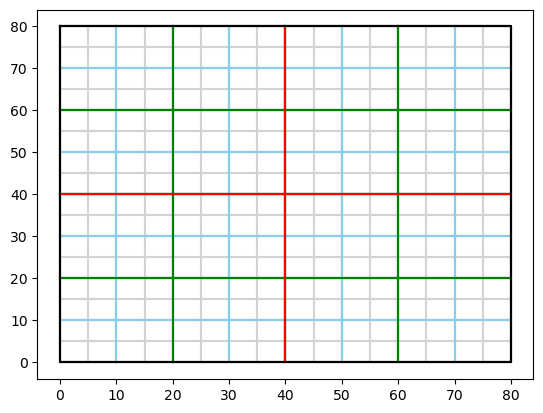

In [8]:
fig, ax = plt.subplots()

for i in range(4):
    for j in range(4):
        for k in range(4):
            for l in range(4):
                draw_rect(qt[i][j][k][l]['bounds'], ax, 'lightgrey')

for i in range(4):
    for j in range(4):
        for k in range(4):
            draw_rect(qt[i][j][k]['bounds'], ax, 'skyblue')

for i in range(4):
    for j in range(4):
        draw_rect(qt[i][j]['bounds'], ax, 'green')

for i in range(4):
    draw_rect(qt[i]['bounds'], ax, 'red')

draw_rect(qt['bounds'], ax, 'black')

plt.show()

The results are spectacular. We see our root node of the quadtree (drawn in black), and the repeated subdivisions of space. For example, level 2 of the quadtree (in red), divides the space into 4 equal squares. Level 3 (drawn in green) of the quadtree, divides each individual square from the previous level into an additional 4 squares. Level 4 corresponds to skyblue, and Level 5 is in light grey. Each one of these squares acts as a spatial query which we can use to test for certain conditions.

The next step is to define a function that tests to see if our input position (camera position) and its search radius intersects with a given level of a quadtree. Since our final implementation will be nested, we only need to test for intersection between one rectangle (corresponding to the quadtree box), and a cicle (corresponding to the camera search radius). Here is what the code looks like.

In [9]:
def is_intersecting(pos: tuple, coords: tuple, threshold=5):
    """
    Docstring for is_intersecting
    
    :param pos: Description
    :type pos: tuple
    :param input_tree: Description
    :param threshold: Description
    """
    camera_x, camera_y = pos
    x_l, x_r, y_t, y_b = coords

    # Find where the camera is with reference to the box

    # Base case for if camera is within the box
    if (x_l < camera_x) & (camera_x < x_r) & (y_b < camera_y) & (camera_y < y_t):
        return True

    # find the X and Y coordinate of the nearest side of the box
    closest_x = max(x_l, min(camera_x, x_r))
    closest_y = max(y_b, min(camera_y, y_t))

    # find the length of the line from camera center to box edge
    curr_dist = (closest_x - camera_x)**2 + (closest_y - camera_y)**2
    
    if curr_dist < threshold**2:
        return True
    else:
        return False

This code was developed in part, with assistance from Google Gemini. This is how it works.

1) Base case: If the X_coordinate and Y_coordinate of our `camera_pos` is within the range of our rectangle, we can say for certain that the camera is within the box and se we return `True`.
2) If the base case is False, that means our camera is somewhere outside our quadtree box. In this case, we need to test if the radius is shorter than the line between the camera and perimeter of the box. How do we get this line? The line connecting the camera to the perimieter of the box, will either be perpedicular to the box (in the case that the circle is directly beside, below or above the box), or diagonal (in the case that the circle is off-axis from the box). The diagram below shows this better.

![Quad Tree Intersection Test-base case](../img/octree-intersection-basecase.png)

![Quad Tree Intersection Test-case1](../img/octree-intersection-case1.png)

![Quad Tree Intersection Test-case2](../img/octree-intersection-case2.png)

![Quad Tree Intersection Test-case3](../img/octree-intersection-case3.png)

For plotting purposes, lets create a color map that will correspond to the different levels in our quadtree.

In [10]:
# Create a color map for the different levels of the quadtree
color_map = {
    0: 'black',
    1: 'red',
    2: 'green',
    3: 'skyblue',
    4: 'lightgrey'
}

Now we define the `draw_quadtree` function. This function will take in the current camera position, and navigate down the levels of the quadtree, only if the current level intersects with the camera's radius (denoted by `threshold`).

In [11]:
def draw_quadtree(pos:tuple, q_tree, threshold=5, level=0):
    """
    Docstring for draw_quadtree
    
    :param pos: Description
    :type pos: tuple
    :param q_tree: Description
    :param threshold: Description
    """
     
    if is_intersecting(pos, q_tree['bounds'], threshold):
        draw_rect(q_tree['bounds'], plt, color_map[level], zorder=5-level)
        try:
            draw_quadtree(pos, q_tree[0], threshold, level = level+1)
        except:
            return
        
        try:
            draw_quadtree(pos, q_tree[1], threshold, level = level+1)
        except:
            return

        try:
            draw_quadtree(pos, q_tree[2], threshold, level = level+1)
        except:
            return
        
        try:
            draw_quadtree(pos, q_tree[3], threshold, level = level+1)
        except:
            return

    return

Let's see what we get when we pass in different values for `camera_pos` and radius `r`.

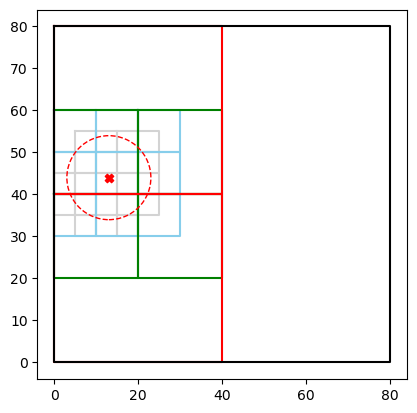

In [12]:
camera_pos = (13,44)
r=10

fig, ax = plt.subplots()

draw_quadtree(camera_pos, qt, threshold=r)

camera_x, camera_y = camera_pos
ax.scatter(camera_x,camera_y, marker='X', color='red', zorder=5)

circle = plt.Circle(camera_pos, r, color='red', fill=False, linestyle='--', zorder=5)
ax.add_patch(circle)

ax.set_aspect('equal')

plt.show()

We see that our function successfully only queries the nodes of the quadtree that are within the specified radius. The remaining nodes are untouched. Now, let's combine this with our `grid` from earlier to see what kind of computational savings we can get.

First, we need to tweak our `draw_quadtree()` function a bit, to also return the `bounds` of each of our quadtrees' lowest level.

In [ ]:
def add_bounds(lst, bounds):
    lst.append(bounds)

def draw_and_get_quadtree(pos:tuple, q_tree, lst, threshold=5, level=0):
    """
    Docstring for draw_and_get_quadtree
    
    :param pos: Description
    :type pos: tuple
    :param q_tree: Description
    :param threshold: Description
    """
    if is_intersecting(pos, q_tree['bounds'], threshold):
        draw_rect(q_tree['bounds'], plt, color_map[level], zorder=5-level)
        
        # If leaf node, add the bounds to the list
        if level == 4:
            add_bounds(lst, q_tree['bounds'])

        try:
            draw_and_get_quadtree(pos, q_tree[0], lst, threshold, level = level+1)
        except:
            return
        
        try:
            draw_and_get_quadtree(pos, q_tree[1], lst, threshold, level = level+1)
        except:
            return

        try:
            draw_and_get_quadtree(pos, q_tree[2], lst, threshold, level = level+1)
        except:
            return
        
        try:
            draw_and_get_quadtree(pos, q_tree[3], lst, threshold, level = level+1)
        except:
            return

    return

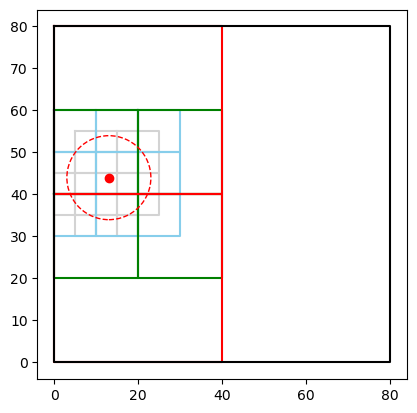

[(5.0, 10.0, 35.0, 30.0), (0, 5.0, 40.0, 35.0), (5.0, 10.0, 40.0, 35.0), (10.0, 15.0, 35.0, 30.0), (15.0, 20.0, 35.0, 30.0), (10.0, 15.0, 40.0, 35.0), (15.0, 20.0, 40.0, 35.0), (20.0, 25.0, 40.0, 35.0), (0, 5.0, 45.0, 40.0), (5.0, 10.0, 45.0, 40.0), (0, 5.0, 50.0, 45.0), (5.0, 10.0, 50.0, 45.0), (10.0, 15.0, 45.0, 40.0), (15.0, 20.0, 45.0, 40.0), (10.0, 15.0, 50.0, 45.0), (15.0, 20.0, 50.0, 45.0), (5.0, 10.0, 55.0, 50.0), (10.0, 15.0, 55.0, 50.0), (15.0, 20.0, 55.0, 50.0), (20.0, 25.0, 45.0, 40.0), (20.0, 25.0, 50.0, 45.0), (20.0, 25.0, 55.0, 50.0)]


In [45]:
index_ranges= []

camera_pos = (13,44)
r=10

fig, ax = plt.subplots()

draw_and_get_quadtree(camera_pos, qt, index_ranges, threshold=r)

camera_x, camera_y = camera_pos
ax.scatter(camera_x,camera_y, marker='o', color='red', zorder=5)

circle = plt.Circle(camera_pos, r, color='red', fill=False, linestyle='--', zorder=5)
ax.add_patch(circle)

ax.set_aspect('equal')

plt.show()
print(index_ranges)

In [42]:
num_objects_qt = 0
objects_found = []

for bounds in index_ranges:
    x_l, x_r, y_t, y_b = bounds

    x_l = int(x_l)
    x_r = int(x_r)
    y_t = int(y_t)
    y_b = int(y_b)

    qt_grid = grid[y_b:(y_t-1), x_l: (x_r-1)]
    num_objects_qt += np.count_nonzero(qt_grid)
    object_indices = qt_grid[qt_grid != 0]
    objects_found.append(object_indices)
    nearest_objects = [ i for i in objects_found if len(i) != 0 ]

num_objects_qt
nearest_objects

[array([3.]),
 array([133.]),
 array([55.]),
 array([194.]),
 array([44.]),
 array([108.]),
 array([178.]),
 array([ 27., 171.])]

This shows the power of spatial indexing. We have ~200 objects in the scene, yet our function is only looping through a fraction of them to determine which objects fall into our search radius.

In [49]:
print(f"Total Objects: {int(np.count_nonzero(grid))}")
print(f"QuadTree Returned Objects: {num_objects_qt}")
print(f"Ratio: {round(num_objects_qt/int(np.count_nonzero(grid)),2)}")

Total Objects: 194
QuadTree Returned Objects: 9
Ratio: 0.05


In [40]:
grid[30:34,5:9]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 3.],
       [0., 0., 0., 0.]])